In [1]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [52]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 'fantasy_points_ppr_roll']

In [29]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp["year"] = pbp["game_id"].apply(lambda x: int(x.split("_")[0]))
rushes = pbp.loc[(pbp.play_type=='run') & (~pbp.yards_gained.isna())].copy(
    deep=True
)


In [35]:
rusher_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[['season', 'team_name', 'week', 'game_type',  'gsis_id', 
       'position', 'depth_position', 'full_name', 'dense_depth',
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_roll',
 'fantasy_points_ppr_roll']]


In [36]:
rushes = rushes.merge(
    rusher_stats,
    left_on=["posteam", "season", "week", "rusher_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
)
rushes

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,carries_roll,rushing_yards_roll,rushing_tds_roll,rushing_first_downs_roll,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_roll,fantasy_points_ppr_roll
0,82.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,13.000000,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000
1,156.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,13.000000,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000
2,201.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,13.000000,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000
3,222.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,13.000000,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000
4,577.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,13.000000,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194691,3751.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,PHI,home,WAS,...,20.145100,113.581922,0.865372,4.927239,1.820060,2.417159,26.638642,0.156754,19.931916,21.751977
194692,3973.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,6.476085,28.898951,0.067896,1.533212,0.000000,0.000000,0.000000,0.000000,15.084039,15.084039
194693,4000.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,4.142536,13.094517,0.296237,1.109361,0.323854,0.476345,0.535579,0.000045,3.140706,3.464560
194694,4052.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,4.142536,13.094517,0.296237,1.109361,0.323854,0.476345,0.535579,0.000045,3.140706,3.464560


In [38]:
rushes['play_end_ydline'] = (rushes['yardline_100'] - rushes['yards_gained'])
rushes = rushes.loc[~rushes.down.isna()].copy(deep=True)

In [53]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    #"total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    #"wind",
    #"temp",
    'spread_line',
    'total_line'
]


full = ['desc','yards_gained', 'play_end_ydline'] + game_context_cols + rusher_stat_cols

In [9]:
rushes['play_end_ydline'] = (rushes['yardline_100'] - rushes['yards_gained'])
rushes = rushes.loc[~rushes.down.isna()][full].copy(deep=True)

In [69]:
rush_yards_cols = (game_context_cols + rusher_stat_cols)
len(rush_yards_cols)

14

In [55]:
rushes['yards_shifted'] = (rushes['yards_gained'] + 30)

In [56]:
rushes['yards_shifted'].min()

4.0

In [61]:
rushes[rush_yards_cols]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,spread_line,total_line,carries_roll,rushing_yards_roll,fantasy_points_ppr_roll
0,78.0,2.0,0,10.0,0.0,0.0,864.0,1764.0,3564.0,-3.0,39.5,13.000000,54.000000,15.400000
1,38.0,1.0,0,10.0,0.0,0.0,772.0,1672.0,3472.0,-3.0,39.5,13.000000,54.000000,15.400000
2,24.0,1.0,0,10.0,0.0,0.0,701.0,1601.0,3401.0,-3.0,39.5,13.000000,54.000000,15.400000
3,22.0,2.0,0,8.0,0.0,0.0,663.0,1563.0,3363.0,-3.0,39.5,13.000000,54.000000,15.400000
4,39.0,1.0,0,10.0,0.0,0.0,387.0,1287.0,3087.0,-3.0,39.5,13.000000,54.000000,15.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194691,39.0,2.0,0,3.0,19.0,9.0,285.0,285.0,285.0,4.5,49.5,20.145100,113.581922,21.751977
194692,43.0,1.0,0,10.0,10.0,-16.0,205.0,205.0,205.0,4.5,49.5,6.476085,28.898951,15.084039
194693,38.0,2.0,0,5.0,10.0,-16.0,199.0,199.0,199.0,4.5,49.5,4.142536,13.094517,3.464560
194694,23.0,2.0,0,1.0,10.0,-16.0,173.0,173.0,173.0,4.5,49.5,4.142536,13.094517,3.464560


In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


(array([2.4045e+04, 5.4043e+04, 6.0142e+04, 3.7820e+04, 1.2965e+04,
        2.5760e+03, 5.2000e+02, 8.8000e+01, 0.0000e+00, 3.3000e+01]),
 array([-12. ,  12.3,  36.6,  60.9,  85.2, 109.5, 133.8, 158.1, 182.4,
        206.7, 231. ]),
 <BarContainer object of 10 artists>)

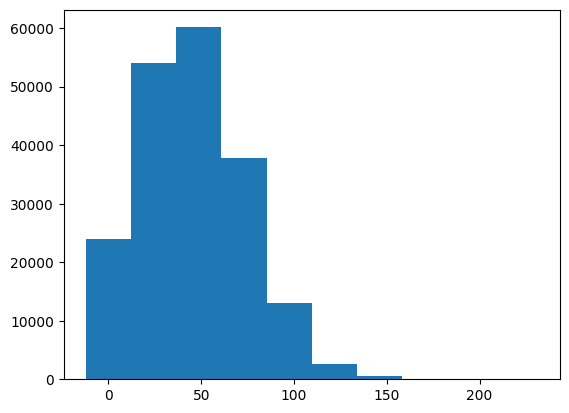

In [108]:
plt.hist(rushes['rushing_yards_roll'])

In [109]:
(game_context_cols + rusher_stat_cols)

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'posteam_score',
 'score_differential',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'spread_line',
 'total_line',
 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll']

In [123]:
rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll']] = rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll']].fillna(0)


In [462]:
rush_yards_cols = (game_context_cols + rusher_stat_cols)#[0:3] + [rusher_stat_cols[-1]]
len(rush_yards_cols)

14

In [558]:
rush_yards_cols = [ 'ydstogo',
 'yardline_100',
 'down',
 'goal_to_go',
 'posteam_score',
 'score_differential',
 'spread_line',
 'total_line',
 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll']

In [559]:
rushes['yards_shifted'] = rushes['yards_gained'].apply(lambda x: max(0, (x+5)))

In [560]:

small = rushes.copy(deep=True)

In [561]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

small = rushes#.loc[rushes.yardline_100 < 10]

X = torch.Tensor((small[rush_yards_cols].values))
y = torch.tensor(small['yards_shifted'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(rush_yards_cols)
# Update the model to match the input and output sizes
class ThreeLayerClassifier(nn.Module):
    def __init__(self, input_size=num_feats, hidden_size=30, output_size=106):
        super(ThreeLayerClassifier, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size + 1, output_size)  # +1 for the additional feature
    def forward(self, x):
        # Extract the feature to pass to the final layer (e.g., the first feature)
        feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
        
        # Pass through the first two layers
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        # Concatenate the extracted feature with the output of the hidden layers
        x = torch.cat((x, feature_to_pass), dim=1)  # Concatenate along the feature axis (dim=1)
        
        # Pass through the final layer
        x = self.output_layer(x)
        return x


# Define the model, loss function, and optimizer
model = ThreeLayerClassifier()
criterion = nn.CrossEntropyLoss()  # Suitable for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Split data into training and testing sets
train_X, test_X = X[obs//5:], X[:obs//5]
train_y, test_y = y[obs//5:], y[:obs//5]

# Training loop
epochs = 20
batch_size = 512

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(train_X.size(0))
    epoch_loss = 0

    for i in range(0, train_X.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = train_X[indices], train_y[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)  # Shape: [batch_size, 100]
        loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_X):.4f}")

# Evaluation on the test set
model.eval()
with torch.no_grad():
    test_preds = model(test_X)  # Shape: [num_samples, 100]
    test_loss = criterion(test_preds, test_y).item()
    accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1/20, Loss: 0.0061
Epoch 2/20, Loss: 0.0056
Epoch 3/20, Loss: 0.0055
Epoch 4/20, Loss: 0.0055
Epoch 5/20, Loss: 0.0055
Epoch 6/20, Loss: 0.0055
Epoch 7/20, Loss: 0.0055
Epoch 8/20, Loss: 0.0054
Epoch 9/20, Loss: 0.0054
Epoch 10/20, Loss: 0.0054
Epoch 11/20, Loss: 0.0054
Epoch 12/20, Loss: 0.0054
Epoch 13/20, Loss: 0.0054
Epoch 14/20, Loss: 0.0054
Epoch 15/20, Loss: 0.0054
Epoch 16/20, Loss: 0.0054
Epoch 17/20, Loss: 0.0054
Epoch 18/20, Loss: 0.0054
Epoch 19/20, Loss: 0.0054
Epoch 20/20, Loss: 0.0054
Test Loss: 2.7797, Test Accuracy: 0.1412


In [ ]:
model_path = "models/run_yards_gained.pt"
torch.save(model.state_dict(), model_path)


In [591]:
feature_config = {
    'rush_yard_cols':rush_yards_cols
}
feature_config

{'rush_yard_cols': ['ydstogo',
  'yardline_100',
  'down',
  'goal_to_go',
  'posteam_score',
  'score_differential',
  'spread_line',
  'total_line',
  'carries_roll',
  'rushing_yards_roll',
  'fantasy_points_ppr_roll']}

In [592]:
yaml_path = "models/feature_config.yaml"
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)  # Load the current content of the YAML file

# Update the data with the provided updates
data.update(feature_config)

with open(yaml_path, "w") as file:
    yaml.safe_dump(data, file)

In [1]:
test = small.loc[small.yardline_100==1][rush_yards_cols+ ['yards_gained','yards_shifted']]
test

NameError: name 'small' is not defined

In [564]:
model(torch.tensor(test[rush_yards_cols].values.tolist())).argmax(dim=1)

tensor([6, 5, 5,  ..., 6, 6, 6])

In [565]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [566]:
X.dtype

torch.float32

In [567]:
torch.Tensor(test.sample(1).values).dtype

torch.float32

im at 1 yard line
can get 1 yard, 0 yds, or negative yards
yards shifted can be 6 or 5
output is [-5, -4, -3, -2, -1, 0, 1]

torch.Size([1, 11])
torch.Size([106])
torch.Size([1, 11])
torch.Size([106])


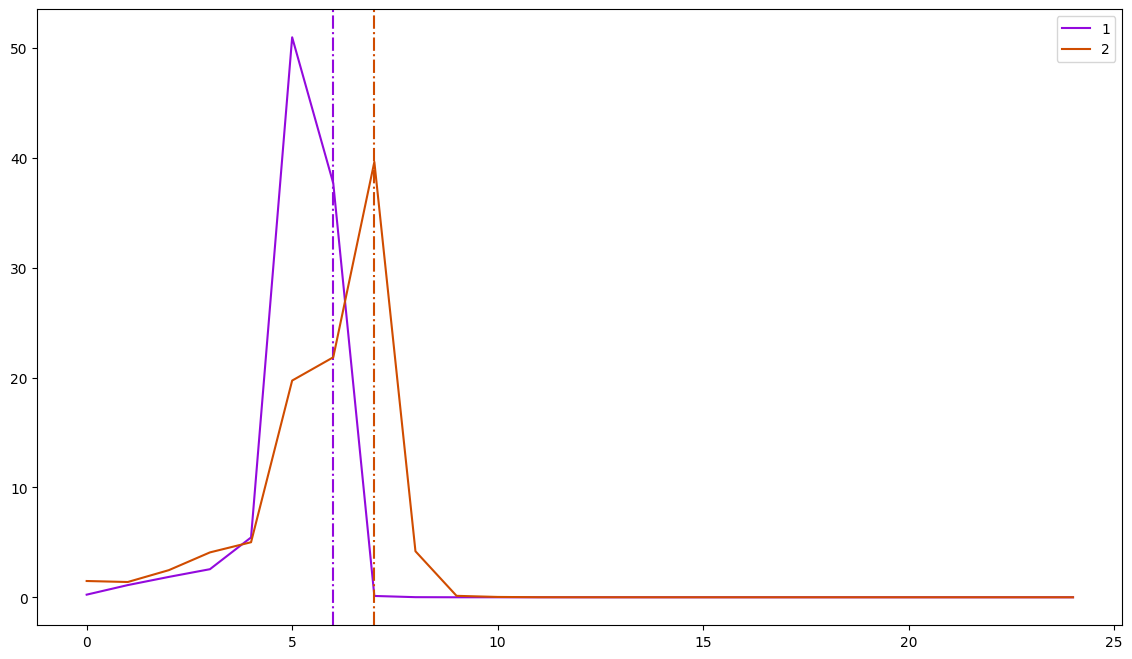

In [569]:
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 3
for yardline in range(1,num_yardlines):
    color = colormap(yardline / num_yardlines) 
    down=1
    test = small.loc[small.yardline_100==yardline]
    xx = torch.Tensor(test[rush_yards_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = model(xx)
        xy = (100 * F.softmax(xy,dim=1))[0]
        print(xy.shape)
        x_range = range(0,25)
    plt.axvline(yardline + 5, color=color, linestyle='-.')
    plt.plot(x_range, xy[0:25], label=yardline, color=color)

plt.legend()

(array([ 1542.,  1361.,  2493.,     0.,  4158.,  5004.,     0., 19757.,
        21872., 43813.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

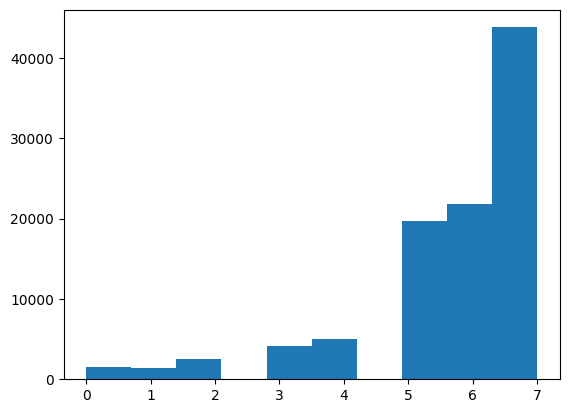

In [588]:
res = model(xx)
res = F.softmax(res,dim=1)[0]
samples = torch.clamp( torch.multinomial(res,100000,replacement=True), max=7)
plt.hist(samples)

<Axes: >

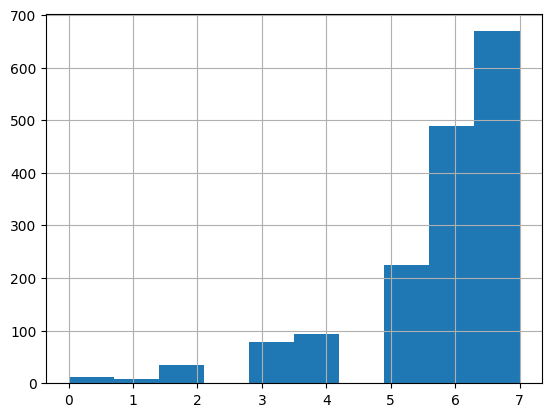

In [585]:
rushes.loc[rushes.yardline_100==2]['yards_shifted'].hist()

In [578]:
unique_values, counts = np.unique(torch.multinomial(res,100000,replacement=True), return_counts=True)

# Combine into a dictionary if needed
value_counts = dict(zip(unique_values, counts))
print(value_counts)

{0: 1423, 1: 1340, 2: 2473, 3: 4072, 4: 4962, 5: 19750, 6: 21817, 7: 39833, 8: 4167, 9: 130, 10: 25, 11: 7, 12: 1}


In [557]:
model(xx)[0][0:15]

tensor([ 9.6374, 10.4172, 11.0791, 11.3591, 12.6232, 14.4422, 14.5139, 15.5944,
        13.6766, 10.0847,  8.2475,  6.2622,  2.9956,  2.8594, -0.1928],
       grad_fn=<SliceBackward0>)

In [553]:
[(x,y) for x,y in zip(xx[0], rush_yards_cols)]

[(tensor(2.), 'ydstogo'),
 (tensor(2.), 'yardline_100'),
 (tensor(2.), 'down'),
 (tensor(1.), 'goal_to_go'),
 (tensor(0.), 'posteam_score'),
 (tensor(0.), 'score_differential'),
 (tensor(7.5167), 'quarter_seconds_remaining'),
 (tensor(22.5167), 'half_seconds_remaining'),
 (tensor(52.5167), 'game_seconds_remaining'),
 (tensor(4.), 'spread_line'),
 (tensor(48.5000), 'total_line'),
 (tensor(1.2753), 'carries_roll'),
 (tensor(3.4580), 'rushing_yards_roll'),
 (tensor(11.2293), 'fantasy_points_ppr_roll')]

In [420]:
rushes.loc[rushes.yardline_100==1]['yards_shifted'].value_counts()

yards_shifted
6.0    2107
5.0    1175
4.0     241
3.0     114
2.0      68
1.0      27
0.0      15
Name: count, dtype: int64

In [383]:
import torch.nn.functional as F

def test_yardline(data, yards, model):
    df = data.loc[data.yardline_100 == yards].copy(deep=True)
    X = torch.tensor(df[rush_yards_cols].values, dtype=torch.float32)
    print(X.shape)
    with torch.no_grad():
        logits = model(X)
        log_probs = F.log_softmax(logits, dim=1)
    real = df['yards_gained'].values
    return real, log_probs

real, preds = test_yardline(rushes, 5, ThreeLayerClassifier())
preds

torch.Size([1503, 2])


tensor([[-8.9882, -5.4124, -8.3221,  ..., -4.7312, -8.0279, -8.6038],
        [-8.9882, -5.4124, -8.3221,  ..., -4.7312, -8.0279, -8.6038],
        [-8.9882, -5.4124, -8.3221,  ..., -4.7312, -8.0279, -8.6038],
        ...,
        [-8.9882, -5.4124, -8.3221,  ..., -4.7312, -8.0279, -8.6038],
        [-8.9882, -5.4124, -8.3221,  ..., -4.7312, -8.0279, -8.6038],
        [-8.9882, -5.4124, -8.3221,  ..., -4.7312, -8.0279, -8.6038]])

In [384]:
model(X[0].reshape(1,-1))

tensor([[-0.4340, -0.7040,  0.2759,  0.7797,  0.2009,  0.9770,  1.4400,  1.5112,
          0.7812,  0.9166, -0.1143,  0.2268, -0.6508, -1.0717, -0.9341, -1.6849,
         -1.0823, -0.5090, -1.5325, -0.6986, -1.9033, -1.0819, -1.4371, -1.0032,
         -1.2512, -1.3337, -0.7753, -1.2143, -1.0720, -0.8927, -0.6031, -0.5764,
         -0.4501, -0.7508, -0.9085, -1.8817, -0.8404, -1.0066, -1.7966, -1.3974,
         -1.8494, -1.3384, -0.6606, -1.4855, -1.7336, -0.3582, -2.0130, -1.6090,
         -1.2197, -0.7489, -0.5621, -0.2860, -0.3420, -0.5296, -1.2504, -1.3422,
         -0.9126, -0.8509, -1.3878, -0.8661, -0.9211, -1.2604, -1.0775, -0.6465,
         -1.5183, -0.3083, -0.7899, -1.1217, -1.4818, -1.7068, -1.6035, -1.1324,
         -1.2606, -0.3636, -1.1748, -1.2080, -1.2997, -0.8629, -2.1455, -0.8797,
         -1.3717, -0.6524, -0.8930, -0.7597, -0.8219, -0.8357, -1.1969, -0.9748,
         -0.5167, -1.2381, -1.3107, -1.1663, -0.7343, -1.0433, -0.7570, -0.5942,
         -0.5312, -1.0403, -

<Axes: >

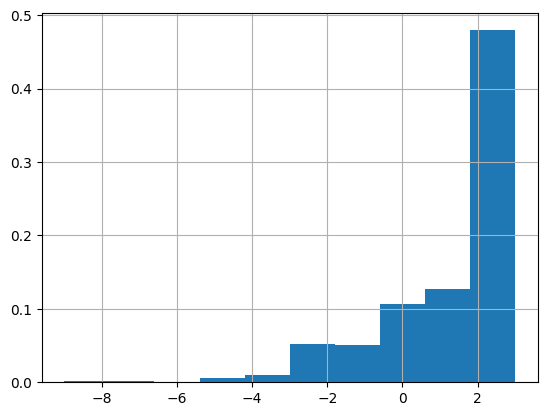

In [386]:
rushes.loc[(rushes.yardline_100 == 3)]['yards_gained'].hist(density=True)

In [389]:
rushes.loc[(rushes.yardline_100 == 3) ]['yards_gained'].values

array([3., 3., 2., ..., 0., 2., 3.], dtype=float32)

In [390]:
rushes.loc[(rushes.yardline_100 == 3)]['yards_gained'].value_counts()

yards_gained
 3.0    497
 2.0    320
 1.0    216
 0.0    181
-1.0     87
-2.0     62
-3.0     26
-4.0     17
-5.0      9
-7.0      2
-8.0      1
-6.0      1
-9.0      1
Name: count, dtype: int64